## Imports...

In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math 
from collections import defaultdict
from math import atan2, degrees, sqrt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

### First load all of the static image gestures. These are gestures that have no movement.

In [2]:
gesture_path = './gestures'
# If you recieve nothing from these lines make sure you have run nthe data_in scripts.
gesture_files = glob.glob("./gestures/*.csv")

def remove_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix):]
    return text


def remove_suffix(text, suffix):
    if text.endswith(suffix):
        return text[: -1 * len(suffix)]
    return text


static_gestures = {}
# iterate through all of the gestures... Static pose is finding the median point of the dataframe.

# TODO: refit the transcription process to lead from correct pose point to pose point. instead of 0-20, 
# we need to do the math to the connecting limb to the center of the heart.
for indx, gesture_file in enumerate(gesture_files):
  
  df = pd.read_csv(gesture_file)
  
  gesture_file = remove_prefix(gesture_file, './gestures/')
  gesture_file = remove_suffix(gesture_file, '.csv')
  
  file_parts = gesture_file.split('_')
  gesture_name = file_parts[0].lower()
  gesture_part = f"{file_parts[2]}".lower()
  if gesture_name == 'one':
    print(gesture_part)

  if df.empty:
      continue
  
  # convert string to time.
  df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S.%f').dt.time
  
  sdf = np.sort(df['time'].to_numpy(), axis=0)
  # Get the lower level bound median
  ts_median = sdf[math.floor(len(sdf) / 2 )]
  
  # Get the static point image/gesture...
  ndf = df[df['time'].isin([ts_median])]
  newGestureData = static_gestures.get(gesture_name, {})
  newGestureData[gesture_part] = ndf
  static_gestures[gesture_name] = newGestureData
  
print(static_gestures['one'])

right
left
pose
{'right':                 time  index         x         y             z
294  00:00:01.928231      0  0.421217  0.673906 -1.109492e-07
295  00:00:01.928231      1  0.403672  0.611394  1.546637e-03
296  00:00:01.928231      2  0.406900  0.548948  2.578361e-03
297  00:00:01.928231      3  0.421388  0.515959  4.016793e-03
298  00:00:01.928231      4  0.437194  0.514636  5.106071e-03
299  00:00:01.928231      5  0.426257  0.522519 -9.479048e-03
300  00:00:01.928231      6  0.433733  0.448504 -1.096984e-02
301  00:00:01.928231      7  0.438970  0.408821 -9.899020e-03
302  00:00:01.928231      8  0.443120  0.377513 -9.628103e-03
303  00:00:01.928231      9  0.449079  0.535689 -1.012208e-02
304  00:00:01.928231     10  0.448800  0.486791 -1.127748e-02
305  00:00:01.928231     11  0.439842  0.502041 -6.422864e-03
306  00:00:01.928231     12  0.433441  0.523711 -2.302012e-03
307  00:00:01.928231     13  0.465129  0.555540 -9.614064e-03
308  00:00:01.928231     14  0.456896  0.521

In [3]:
limb_connections = {
    "thumb": np.array([0, 1, 2, 3, 4]),
    "index": np.array([0, 5, 6, 7, 8]),
    "middle": np.array([0, 9, 10, 11, 12]),
    "ring": np.array([0, 13, 14, 15, 16]),
    "pinky": np.array([0, 17, 18, 19, 20]),
    "palm": np.array([2, 5, 9, 13, 17]),
    "sequential": np.arange(0, 21),
}

coordinates = static_gestures["one"]["right"].to_numpy()[:, 2:]


def angle_between_360(angle):
    """Get the angle between 0 and 360."""
    return angle if angle >= 0 else 360 + angle


def get_angles(coordinates: np.array, connections: dict[str, np.array]) -> np.array:
    """ "
    Get the angles of each vector formed by the coordinates and the connections.

    Inputs:
        coordinates: np.array
            A 2D array containing the coordinates of the points.
        connections: dict[str, np.array]
            A dictionary containing the connections between the points.
            Each element of the dictionary is a 1D array containing the indexes of the points.

    Outputs:
        angles: dict[str, np.array]
            A 3D array containing the angles between the vectors.
            The size of the array is (connections.shape[0], connections.shape[1]-1,3).
    """
    # angles = np.zeros((connections.shape[0], connections.shape[1] - 1, 3))
    angles = {}
    for key in connections:
        angles[key] = np.zeros((connections[key].shape[0] - 1, 3))
        for j in range(connections[key].shape[0] - 1):
            v = [
                coordinates[connections[key][j + 1], 0]
                - coordinates[connections[key][j], 0],
                coordinates[connections[key][j + 1], 1]
                - coordinates[connections[key][j], 1],
                coordinates[connections[key][j + 1], 2]
                - coordinates[connections[key][j], 2],
            ]
            angles[key][j, 0] = angle_between_360(degrees(atan2(v[1], v[2])))
            angles[key][j, 1] = angle_between_360(
                degrees(atan2(-v[0], sqrt(v[1] ** 2 + v[2] ** 2)))
            )
            angles[key][j, 2] = angle_between_360(degrees(atan2(v[0], -v[1])))
    return angles


angles = get_angles(coordinates, limb_connections)

In [4]:
def get_angles_vec_coordinates(coordinates: np.array) -> np.array:
    """ "
    Get the angles of each vector formed by the coordinates.

    Inputs:
        coordinates: np.array
            A 2D array containing the coordinates of the points.
        connections: dict[str, np.array]
            A dictionary containing the connections between the points.
            Each element of the dictionary is a 1D array containing the indexes of the points.

    Outputs:
        angles: np.array
            A 3D array containing the angles between the vectors.
            The size of the array is (connections.shape[0], connections.shape[1]-1,3).
    """
    # angles = np.zeros((connections.shape[0], connections.shape[1] - 1, 3))
    angles = np.zeros((coordinates.shape[0], 2))
    for i in range(coordinates.shape[0]):
        v = coordinates[i].astype(float)
        # angles[i, 0] = angle_between_360(degrees(atan2(v[1], v[2])))
        # angles[i, 1] = angle_between_360(
        #     degrees(atan2(-v[0], sqrt(v[1] ** 2 + v[2] ** 2)))
        # )
        # angles[i, 2] = angle_between_360(degrees(atan2(v[0], -v[1])))
        r = np.sqrt(sum(v**2))
        rxy = np.sqrt(v[0]**2 + v[1]**2)
        if rxy == 0:
            rxy = 1e-4
        if r == 0:
            r = 1e-4
        angles[i, 0] = angle_between_360(degrees(np.arccos(v[2]/r)))
        angles[i, 1] = np.sign(v[1]) * angle_between_360(degrees(np.arccos(v[0]/rxy)))
        
    return angles

We need to create a function that, given the coordinates of the points, returns the hand frame of reference in the global frame of reference. 

The y base vector goes from point 0 to point 9. The other base vectors are more complicated. 
One idea is to make the x base parallel with the line that best fits points 5, 9, 13 and 17.
Another idea is to define the z vector as being perpendicular to the plane that passes trough points 0, 5, 17.
Either way, once the x or z vectors are defined they automatically define the other (which is just perpendicular to all the others).
One problem is that they don't necessarily, according to my definitions, need to be perdicular to y to begin with.

Fix to all that. Make the y base vector go from 0 to 5, the plane that defines z intersects 0, 5 and 17. Now y and z are guaranteed to be perpendicular. 

Now I just need to remember how one defines a base vector perpendicular to a plane. Just be fast, will be back in a minute.

In [5]:
def hand_frame_of_reference(coordinates: np.array) -> np.array:
    """Get the hand frame of reference.

    Inputs:
        coordinates: np.array
            A 2D array containing the coordinates of the points.
            Coordinates are expected to be sorted according to their index.

    Outputs:
        hand_frame: np.array
            A 2D array containing the base vectors of the hand frame of reference in global coordinates.
    """
    hand_frame = np.zeros((3, 3))
    # the plane passes through the points 0, 5, and 17
    points_in_plane = coordinates[[0, 5, 17]].astype(float)
    # The z vector is the cross product of the vectors formed by the points 0-5 and 0-17
    # It's a vector normal to the plane.
    z_vec = np.cross(
        points_in_plane[1] - points_in_plane[0], points_in_plane[2] - points_in_plane[0]
    )
    # The z base vector is the normalized z vector
    hand_frame[2] = z_vec / np.linalg.norm(z_vec)
    # The y vector is the vector formed by the points 0 and 5
    y_vec = points_in_plane[2] - points_in_plane[0]
    # The y base vector is the normalized y vector
    hand_frame[1] = y_vec / np.linalg.norm(y_vec)
    # The x base vector is the cross product of the y and z base vectors
    hand_frame[0] = np.cross(hand_frame[2], hand_frame[1])
    return hand_frame

In [134]:
def to_hand_frame(coordinates: np.array) -> np.array:
    """Rotate and translates the coordinates to the hand frame of reference.

    Inputs:
        coordinates: np.array
            A 2D array containing the coordinates of the points to rotate.

    Outputs:
        coordinates_hand_frame: np.array
            A 2D array containing the coordinates of the points in the hand frame of reference.
    """
    coordinates = coordinates.astype(float)
    # The hand frame of reference is obtained by the hand_frame_of_reference function.
    hand_frame = hand_frame_of_reference(coordinates)
    # The rotation matrix is the transpose of the hand frame of reference.
    rotation_matrix = hand_frame.T
    # The coordinates in the hand frame of reference are obtained by multiplying the rotation matrix by the coordinates.
    coordinates_hand_frame = np.zeros_like(coordinates)
    for i in range(coordinates.shape[0]):
        coordinates_hand_frame[i] = np.dot(rotation_matrix, coordinates[i] - coordinates[0]) 
    return coordinates_hand_frame

In [135]:
def match_sequential_angles(base_angles: np.array, angles: np.array) -> bool:
    """Match the angles to the base angles.

    Inputs:
        base_angles: np.array
            A 2D array containing the base angles.
        angles: np.array
            A 2D array containing the angles to be matched.

    Outputs:
        matched_angles: bool
            A boolean indicating if the angles match the base angles.
    """
    max_error = 10
    # is_a_match = True

    # for idx in range(base_angles.shape[0]):
    #     x_angle = angles[idx, 0]
    #     y_angle = angles[idx, 1]
    #     z_angle = angles[idx, 2]

    #     base_x = base_angles[idx, 0]
    #     base_y = base_angles[idx, 1]
    #     base_z = base_angles[idx, 2]

    #     # Compute the error
    #     x_error = abs(base_x - x_angle)
    #     y_error = abs(base_y - y_angle)
    #     z_error = abs(base_z - z_angle)

    #     if (x_error > max_error) or (y_error > max_error) or (z_error > max_error):
    #         is_a_match = False
    # return is_a_match
    return np.all(np.abs(base_angles - angles) < max_error)
    

We want to make a match_sequential_angles function that takes into account the vectors measured in the hand frame of reference.

Point $A_g$ is a point in 3D space measured in the global coordinate system. The same point can be measured in the hand frame of reference, which would be represented as $A_h$. The hand frame of reference has a position $H$ in the global coordinate system. To find the position $A_h$ in the hand frame one just needs to consider that $A_g = H + A_h$, thus, $A_h = A_g - H$.

Since the origin of the hand frame of reference is the 0 point of the hand, to calculate the positions of the points in the hand frame of reference, one just needs to subract them all of the zero point and then rotate to the hand frame of reference.

The match_sequential_angles function matches the sequential angles, regardless of their coordinate system. To get the angles in the hand frame of reference one just needs to take into account the vectors measured in the hand frame of reference. Which is done below.

In [136]:
# Loop through our images to a static pose we know works.

all_gestures = static_gestures.keys()

# Proof of concept for the hand gesture "1"
test_pose_name = "one"
static_base_gesture = static_gestures[test_pose_name]["right"].to_numpy()
static_base_points = static_base_gesture[:, 2:]
static_base_points_in_hand_frame = to_hand_frame(static_base_points)


In [137]:

angles_base = get_angles_vec_coordinates(static_base_points_in_hand_frame)
# angles_base = get_angles(static_base_points_in_hand_frame, limb_connections)['sequential']

for pose_name in all_gestures:
    # print(pose_name)
    pose = static_gestures[pose_name]
    if pose.get("right", False) is False:
        continue
    pose_points = pose["right"].to_numpy()[:, 2:]
    pose_points_in_hand = to_hand_frame(pose_points)

    angles = get_angles_vec_coordinates(pose_points_in_hand)
    # angles = get_angles(pose_points_in_hand, limb_connections)['sequential']

    is_a_match = match_sequential_angles(angles_base, angles)

    if is_a_match:
        print(
            f"The Pose {pose_name} matches the pose {test_pose_name} right in the middle of the video"
        )
        # Within a threshold, say the pose is correct or not...
        # TODO: Add more test cases here, maybe add your own pictures in.....

    # This is the hard part... We need to fine tune the model for every static pose..
    # TODO: fine tune our error function to work for only the pose we want it to and no other poses.

The Pose one matches the pose one right in the middle of the video
The Pose advocacy matches the pose one right in the middle of the video


### Test if match_sequential_angles works correctly for the same pose in its video

In [138]:
for indx, gesture_file in enumerate(gesture_files):
    gesture_file_cl = remove_prefix(gesture_file, './gestures/')
    gesture_file_cl = remove_suffix(gesture_file_cl, '.csv')

    file_parts = gesture_file_cl.split('_')
    gesture_name = file_parts[0].lower()
    gesture_part = f"{file_parts[2]}".lower()
    if gesture_name == 'one':
        if gesture_part == 'right':
            print(gesture_file)
            df = pd.read_csv(gesture_file)

# convert string to time.
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S.%f').dt.time



./gestures/ONE_Transcription_Right_Hand.csv


In [139]:
df.sort_values(by=['time'], inplace=True)

In [140]:
times = df['time'].to_numpy()

In [141]:
count_right_identified = 0
count_wrong_identified = 0
for time in times:
    df_t = df[df["time"] == time]
    df_t_sorted = df_t.sort_values(by=['index'])
    pose = df_t_sorted.to_numpy()[:, 2:]
    pose_in_hand = to_hand_frame(pose)
    angles = get_angles_vec_coordinates(pose_in_hand)
    # angles = get_angles(pose_in_hand, limb_connections)['sequential']
    is_a_match = match_sequential_angles(angles_base, angles)
    if is_a_match:
        count_right_identified += 1
count_wrong_identified = len(times) - count_right_identified

In [142]:
count_right_identified

378

In [143]:
count_wrong_identified

210

Quick animation using the pose points

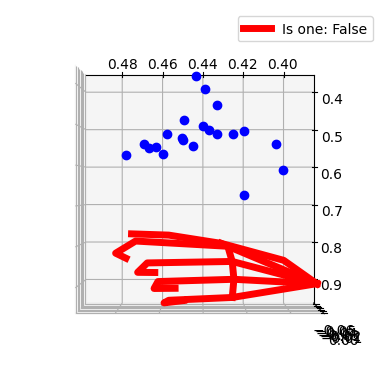

In [144]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.view_init(90, 180, 90)
xdata, ydata, zdata = [], [], []
ln1, = ax.plot([], [], [], 'r',lw=5,label='Is one: False')
ln2, = ax.plot([], [], [], 'r',lw=5)
ln3, = ax.plot([], [], [], 'r',lw=5)
ln4, = ax.plot([], [], [], 'r',lw=5)
ln5, = ax.plot([], [], [], 'r',lw=5)
ln6, = ax.plot([], [], [], 'r',lw=5)
lnref, = ax.plot([], [], [], 'bo',lw=5)
L=plt.legend(loc=1) #Define legend objects

def init():
    ax.set_xlim(df['x'].min(),df['x'].max())
    ax.set_ylim(df['y'].min(),df['y'].max())
    ax.set_zlim(df['z'].min(),df['z'].max())
    return ln1, ln2, ln3, ln4, ln5, ln6, lnref

def update(t):
    # Get data sorted by index at time t
    df_t = df[df["time"] == t]
    df_t_sorted = df_t.sort_values(by=['index'])
    pose = df_t_sorted.to_numpy()[:, 2:]
    # get the data of each limb
    ln1_data = pose[limb_connections['thumb'],:]
    ln2_data = pose[limb_connections['index'],:]
    ln3_data = pose[limb_connections['middle'],:]
    ln4_data = pose[limb_connections['ring'],:]
    ln5_data = pose[limb_connections['pinky'],:]
    ln6_data = pose[limb_connections['palm'],:]
    # Update the data of each limb
    ln1.set_data(ln1_data[:,0], ln1_data[:,1])
    ln1.set_3d_properties(ln1_data[:,2])
    ln2.set_data(ln2_data[:,0], ln2_data[:,1])
    ln2.set_3d_properties(ln2_data[:,2])
    ln3.set_data(ln3_data[:,0], ln3_data[:,1])
    ln3.set_3d_properties(ln3_data[:,2])
    ln4.set_data(ln4_data[:,0], ln4_data[:,1])
    ln4.set_3d_properties(ln4_data[:,2])
    ln5.set_data(ln5_data[:,0], ln5_data[:,1])
    ln5.set_3d_properties(ln5_data[:,2])
    ln6.set_data(ln6_data[:,0], ln6_data[:,1])
    ln6.set_3d_properties(ln6_data[:,2])
    lnref.set_data(static_base_gesture[:,2], static_base_gesture[:,3])
    lnref.set_3d_properties(static_base_gesture[:,4])
    # Get the angles of the pose
    angles = get_angles_vec_coordinates(to_hand_frame(pose))
    # angles = get_angles(to_hand_frame(pose), limb_connections)['sequential']
    is_a_match = match_sequential_angles(angles_base, angles)
    if is_a_match:
        L.get_texts()[0].set_text('Is one: True')
    else:
        L.get_texts()[0].set_text('Is one: False') #Update label each at frame
    return ln1, ln2, ln3, ln4, ln5, ln6, lnref

ani = FuncAnimation(fig, update, frames=times,
                    init_func=init, blit=True, interval=20)

HTML(ani.to_html5_video())

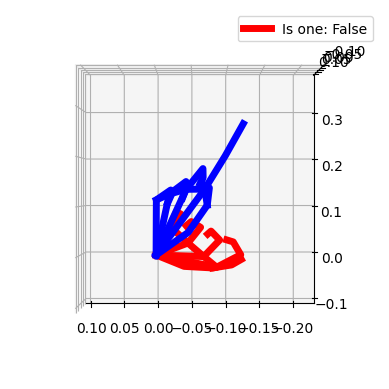

In [145]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.view_init(-90, 90, 0)
xdata, ydata, zdata = [], [], []
ln1, = ax.plot([], [], [], 'r',lw=5,label='Is one: False')
ln2, = ax.plot([], [], [], 'r',lw=5)
ln3, = ax.plot([], [], [], 'r',lw=5)
ln4, = ax.plot([], [], [], 'r',lw=5)
ln5, = ax.plot([], [], [], 'r',lw=5)
ln6, = ax.plot([], [], [], 'r',lw=5)
ln_ref1, = ax.plot([], [], [], 'b',lw=5)
ln_ref2, = ax.plot([], [], [], 'b',lw=5)
ln_ref3, = ax.plot([], [], [], 'b',lw=5)
ln_ref4, = ax.plot([], [], [], 'b',lw=5)
ln_ref5, = ax.plot([], [], [], 'b',lw=5)
ln_ref6, = ax.plot([], [], [], 'b',lw=5)
L=plt.legend(loc=1) #Define legend objects

def init():
    ax.set_xlim(static_base_points_in_hand_frame[:,0].min()-.1,static_base_points_in_hand_frame[:,0].max()+.1)
    ax.set_ylim(static_base_points_in_hand_frame[:,1].min()-.1,static_base_points_in_hand_frame[:,1].max()+.1)
    ax.set_zlim(static_base_points_in_hand_frame[:,2].min()-.1,static_base_points_in_hand_frame[:,2].max()+.1)
    return ln1, ln2, ln3, ln4, ln5, ln6, ln_ref1, ln_ref2, ln_ref3, ln_ref4, ln_ref5, ln_ref6

def update(t):
    # Get data sorted by index at time t
    df_t = df[df["time"] == t]
    df_t_sorted = df_t.sort_values(by=['index'])
    pose = to_hand_frame(df_t_sorted.to_numpy()[:, 2:])
    # get the data of each limb
    ln1_data = pose[limb_connections['thumb'],:]
    ln2_data = pose[limb_connections['index'],:]
    ln3_data = pose[limb_connections['middle'],:]
    ln4_data = pose[limb_connections['ring'],:]
    ln5_data = pose[limb_connections['pinky'],:]
    ln6_data = pose[limb_connections['palm'],:]
    # get the ref data of each limb
    ln_ref1_data = static_base_points_in_hand_frame[limb_connections['thumb'],:]
    ln_ref2_data = static_base_points_in_hand_frame[limb_connections['index'],:]
    ln_ref3_data = static_base_points_in_hand_frame[limb_connections['middle'],:]
    ln_ref4_data = static_base_points_in_hand_frame[limb_connections['ring'],:]
    ln_ref5_data = static_base_points_in_hand_frame[limb_connections['pinky'],:]
    ln_ref6_data = static_base_points_in_hand_frame[limb_connections['palm'],:]
    # Update the data of each limb
    ln1.set_data(ln1_data[:,0], ln1_data[:,1])
    ln1.set_3d_properties(ln1_data[:,2])
    ln2.set_data(ln2_data[:,0], ln2_data[:,1])
    ln2.set_3d_properties(ln2_data[:,2])
    ln3.set_data(ln3_data[:,0], ln3_data[:,1])
    ln3.set_3d_properties(ln3_data[:,2])
    ln4.set_data(ln4_data[:,0], ln4_data[:,1])
    ln4.set_3d_properties(ln4_data[:,2])
    ln5.set_data(ln5_data[:,0], ln5_data[:,1])
    ln5.set_3d_properties(ln5_data[:,2])
    ln6.set_data(ln6_data[:,0], ln6_data[:,1])
    ln6.set_3d_properties(ln6_data[:,2])
    # Update the ref data of each limb
    ln_ref1.set_data(ln_ref1_data[:,0], ln_ref1_data[:,1])
    ln_ref1.set_3d_properties(ln_ref1_data[:,2])
    ln_ref2.set_data(ln_ref2_data[:,0], ln_ref2_data[:,1])
    ln_ref2.set_3d_properties(ln_ref2_data[:,2])
    ln_ref3.set_data(ln_ref3_data[:,0], ln_ref3_data[:,1])
    ln_ref3.set_3d_properties(ln_ref3_data[:,2])
    ln_ref4.set_data(ln_ref4_data[:,0], ln_ref4_data[:,1])
    ln_ref4.set_3d_properties(ln_ref4_data[:,2])
    ln_ref5.set_data(ln_ref5_data[:,0], ln_ref5_data[:,1])
    ln_ref5.set_3d_properties(ln_ref5_data[:,2])
    ln_ref6.set_data(ln_ref6_data[:,0], ln_ref6_data[:,1])
    ln_ref6.set_3d_properties(ln_ref6_data[:,2])
    # Get the angles of the pose
    angles = get_angles_vec_coordinates(pose)
    # angles = get_angles(pose, limb_connections)['sequential']
    is_a_match = match_sequential_angles(angles_base, angles)
    if is_a_match:
        L.get_texts()[0].set_text('Is one: True')
    else:
        L.get_texts()[0].set_text('Is one: False') #Update label each at frame
    return ln1, ln2, ln3, ln4, ln5, ln6, ln_ref1, ln_ref2, ln_ref3, ln_ref4, ln_ref5, ln_ref6

ani = FuncAnimation(fig, update, frames=times,
                    init_func=init, blit=True, interval=10)

HTML(ani.to_html5_video())